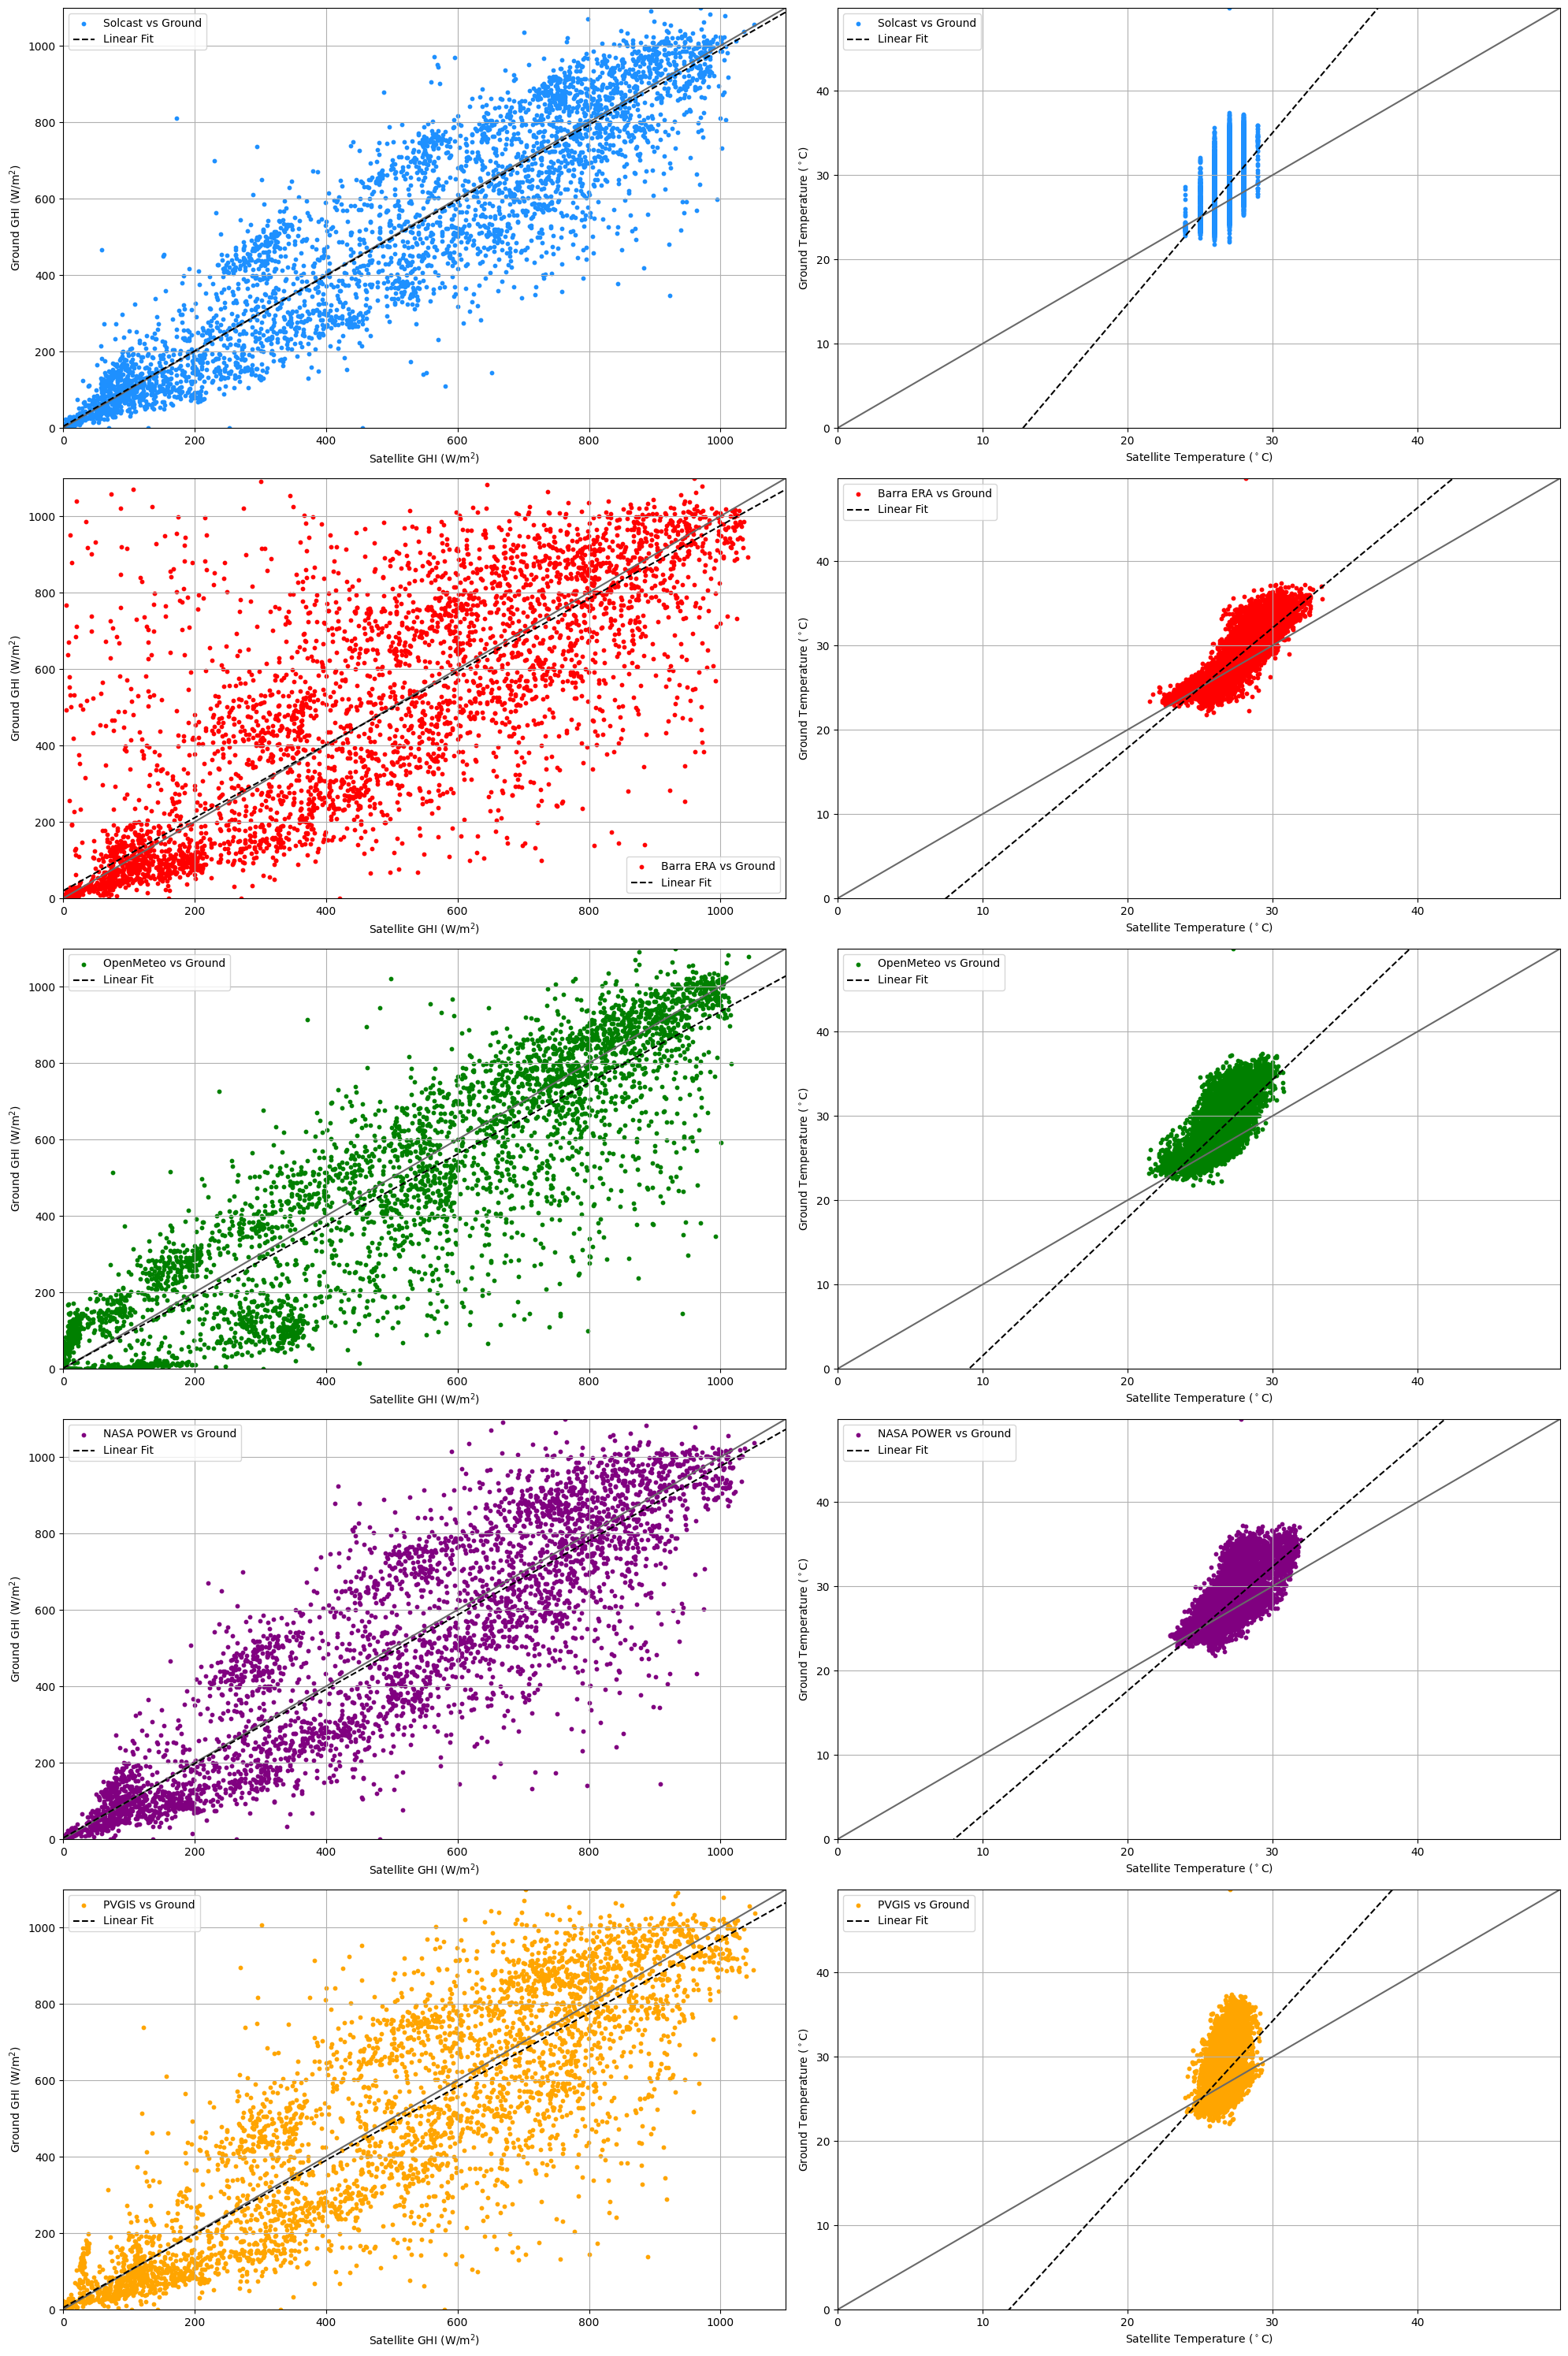

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define the function for plotting
def plot_NREL_scatter(df):
    # Colors for better distinction
    colors = ['dodgerblue', 'red', 'green', 'purple', 'orange']
    # Define subplots (5 datasets, 2 columns for GHI and Temperature)
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))
    
    # Dataset column groups for satellite data
    satellite_ghis = ['GHI_sc', 'GHI_be', 'GHI_om', 'GHI_np', 'GHI_pg']
    satellite_ts = ['T_sc', 'T_be', 'T_om', 'T_np', 'T_pg']
    dataset_labels = ['Solcast', 'Barra ERA', 'OpenMeteo', 'NASA POWER', 'PVGIS']

    # Ground truth data
    ground_ghi = 'GHI1'
    ground_t = 'T1'

    # Loop through the datasets
    for i in range(5):
        for j in range(2):
            x = df[satellite_ghis[i]] if j == 0 else df[satellite_ts[i]]
            y = df[ground_ghi] if j == 0 else df[ground_t]
            xlabel = 'Satellite GHI (W/m$^2$)' if j == 0 else 'Satellite Temperature ($^\circ$C)'
            ylabel = 'Ground GHI (W/m$^2$)' if j == 0 else 'Ground Temperature ($^\circ$C)'

            # Clear NaN values
            mask = ~np.isnan(x) & ~np.isnan(y)
            x = x[mask]
            y = y[mask]

            # Scatter plot with different color
            ax[i, j].scatter(x, y, s=10, color=colors[i], label=f'{dataset_labels[i]} vs Ground')
            
            # Line of perfect agreement
            xy_max = max(x.max(), y.max(), y.min())
            ax[i, j].plot([0, xy_max], [0, xy_max], '-', color='dimgrey', lw=1.5)
            
            # Linear regression
            fit = linregress(x, y)
            xvals = np.linspace(0, xy_max, 100)
            yvals = fit.slope * xvals + fit.intercept
            ax[i, j].plot(xvals, yvals, '--', color='black', lw=1.5, label='Linear Fit')
            
            # Labeling and setting limits
            ax[i, j].set_xlabel(xlabel)
            ax[i, j].set_ylabel(ylabel)
            ax[i, j].set_xlim(0, xy_max)
            ax[i, j].set_ylim(0, xy_max)
            ax[i, j].grid(True)
            ax[i, j].legend()

    plt.tight_layout()
    plt.show()

# Load data
file_path = 'D:/ictpep/dataset/compiled.csv'
df_hourly = pd.read_csv(file_path)

# Call the plotting function
plot_NREL_scatter(df_hourly)



In [3]:
import pandas as pd
import numpy as np

# Load the dataset
path = r'D:\ictpep\dataset\compiled.csv'
data = pd.read_csv(path)

# Extract hour from time for day-night classification
data['Hour'] = pd.to_datetime(data['Time']).dt.hour

# Define reference data
ref_ghi = data['GHI1']
ref_temp = data['T1']

# Daytime (6 am to 6 pm) and nighttime (6 pm to 6 am)
daytime = data[(data['Hour'] >= 6) & (data['Hour'] < 18)]
nighttime = data[(data['Hour'] < 6) | (data['Hour'] >= 18)]

# Satellite data columns
satellite_sources = ['sc', 'be', 'om', 'np', 'pg']

# Functions to calculate metrics
def mbd(y_true, y_pred):
    return np.mean(y_pred - y_true)

def rmsd(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def nmbd(y_true, y_pred):
    return mbd(y_true, y_pred) / np.mean(y_true)

def nrmsd(y_true, y_pred):
    return rmsd(y_true, y_pred) / np.mean(y_true)

# Function to calculate metrics for specific period
def calculate_metrics(df, ref_ghi_col, ref_temp_col, src_ghi_col, src_temp_col):
    ghi_pred = df[src_ghi_col]
    temp_pred = df[src_temp_col]

    return {
        'GHI_MBD': mbd(df[ref_ghi_col], ghi_pred),
        'GHI_nMBD': nmbd(df[ref_ghi_col], ghi_pred),
        'GHI_RMSD': rmsd(df[ref_ghi_col], ghi_pred),
        'GHI_nRMSD': nrmsd(df[ref_ghi_col], ghi_pred),
        'GHI_Correlation': df[ref_ghi_col].corr(ghi_pred),
        'Temp_MBD': mbd(df[ref_temp_col], temp_pred),
        'Temp_nMBD': nmbd(df[ref_temp_col], temp_pred),
        'Temp_RMSD': rmsd(df[ref_temp_col], temp_pred),
        'Temp_nRMSD': nrmsd(df[ref_temp_col], temp_pred),
        'Temp_Correlation': df[ref_temp_col].corr(temp_pred)
    }

# Calculate metrics for each satellite source
results = []
for src in satellite_sources:
    overall_metrics = calculate_metrics(data, 'GHI1', 'T1', f'GHI_{src}', f'T_{src}')
    daytime_metrics = calculate_metrics(daytime, 'GHI1', 'T1', f'GHI_{src}', f'T_{src}')
    nighttime_metrics = calculate_metrics(nighttime, 'GHI1', 'T1', f'GHI_{src}', f'T_{src}')

    results.append({
        'Satellite Source': src,
        **{f'Overall_{key}': val for key, val in overall_metrics.items()},
        **{f'Daytime_{key}': val for key, val in daytime_metrics.items()},
        **{f'Nighttime_{key}': val for key, val in nighttime_metrics.items()}
    })

# Compile results into a DataFrame
results_df = pd.DataFrame(results)

# Display styled results
def highlight_bold(s):
    return ['font-weight: bold']*len(s)

styled_df = results_df.style.apply(highlight_bold, axis=1)
display(styled_df)

# Optionally save results to CSV
results_df.to_csv(r'D:\ictpep\dataset\satellite_error_metricsz.csv', index=False)

,Satellite Source,Overall_GHI_MBD,Overall_GHI_nMBD,Overall_GHI_RMSD,Overall_GHI_nRMSD,Overall_GHI_Correlation,Overall_Temp_MBD,Overall_Temp_nMBD,Overall_Temp_RMSD,Overall_Temp_nRMSD,Overall_Temp_Correlation,Daytime_GHI_MBD,Daytime_GHI_nMBD,Daytime_GHI_RMSD,Daytime_GHI_nRMSD,Daytime_GHI_Correlation,Daytime_Temp_MBD,Daytime_Temp_nMBD,Daytime_Temp_RMSD,Daytime_Temp_nRMSD,Daytime_Temp_Correlation,Nighttime_GHI_MBD,Nighttime_GHI_nMBD,Nighttime_GHI_RMSD,Nighttime_GHI_nRMSD,Nighttime_GHI_Correlation,Nighttime_Temp_MBD,Nighttime_Temp_nMBD,Nighttime_Temp_RMSD,Nighttime_Temp_nRMSD,Nighttime_Temp_Correlation
0,sc,-0.662276,-0.002769,81.901001,0.342425,0.968073,-1.374664,-0.049326,3.103784,0.111372,0.577671,-0.715004,-0.001498,115.812135,0.242581,0.930506,-3.367618,-0.111971,4.269599,0.141962,0.610322,-0.609534,-0.690842,1.193423,1.352617,0.873805,0.618788,0.024114,1.017510,0.039652,0.724523
1,be,-9.359950,-0.039134,141.973782,0.593588,0.901777,-0.827881,-0.029706,1.936618,0.069491,0.877772,-18.233339,-0.038192,200.765352,0.420524,0.784934,-1.770560,-0.058870,2.633286,0.087555,0.806739,-0.484347,-0.548955,1.163690,1.318918,0.883154,0.115034,0.004483,0.752320,0.029317,0.805165
2,om,15.590375,0.065183,106.372965,0.444742,0.948958,-1.786092,-0.064089,3.015211,0.108193,0.709075,22.959147,0.048090,147.375015,0.308693,0.892768,-3.544914,-0.117866,4.181567,0.139035,0.744397,8.219764,9.316218,30.140066,34.160520,0.667812,-0.026832,-0.001046,0.833908,0.032497,0.744173
3,np,3.638046,0.015211,100.027686,0.418212,0.952276,-0.888404,-0.031878,2.494359,0.089504,0.725345,7.925135,0.016600,141.446926,0.296276,0.894752,-2.462306,-0.081870,3.362011,0.111785,0.688691,-0.650113,-0.736833,1.160599,1.315414,0.896476,0.685891,0.026729,1.067363,0.041594,0.779872
4,pg,3.750994,0.015683,109.939302,0.459652,0.942241,-1.241418,-0.044545,3.153791,0.113166,0.484602,8.238154,0.017256,155.459973,0.325627,0.872047,-3.350919,-0.111416,4.303899,0.143102,0.556658,-0.737286,-0.835634,1.575378,1.785521,0.752630,0.868609,0.033849,1.169236,0.045564,0.746797


In [43]:
# FINAL SCRIPT: LSTM GHI Prediction with Satellite + Temperature Input
# Includes day/night evaluation, model saving, and complete CSV logging

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import time

# === CONFIGURATION ===
base_path = r'D:\ictpep\dataset'
data_file = os.path.join(base_path, 'compiled.csv')
model_dir = os.path.join(base_path, 'models_final_ground')
plot_dir = os.path.join(base_path, 'plots_final_ground')
result_dir = os.path.join(base_path, 'results_final_ground')
test_summary_path = os.path.join(result_dir, 'test_summary.csv')
train_summary_path = os.path.join(result_dir, 'train_summary.csv')
comparison_path = os.path.join(result_dir, 'comparison_summary.csv')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

satellites = ['2']
TIMESTEPS = 24

# === FUNCTIONS ===
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def calc_metrics(true, pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred),
        'R2': r2_score(true, pred)
    }

def append_csv(path, row):
    file_exists = os.path.isfile(path)
    pd.DataFrame([row]).to_csv(path, mode='a', index=False, header=not file_exists)

# === MAIN LOOP ===
for sat in satellites:
    print(f"\n🚀 Training model for satellite: {sat.upper()}")
    start_time = time.time()
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    ghi_col = f'GHI_{sat}'
    tsat_col = f'T_{sat}'
    tground_col = 'T1'
    target_col = 'GHI1'
    time_col = 'Time'

    df = pd.read_csv(data_file)
    df['Time'] = pd.to_datetime(df['Time'])
    df = df[[ghi_col, tsat_col, tground_col, target_col, time_col]].dropna()
    df['hour'] = df['Time'].dt.hour

    # === With Temp ===
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[[ghi_col, tsat_col, tground_col, target_col]])
    X_temp, y_temp, times_temp = [], [], []
    for i in range(TIMESTEPS, len(scaled)):
        X_temp.append(scaled[i - TIMESTEPS:i, :3])
        y_temp.append(scaled[i, 3])
        times_temp.append(df['Time'].iloc[i])
    X_temp, y_temp = np.array(X_temp), np.array(y_temp)
    split = int(0.8 * len(X_temp))
    X_train_temp, X_test_temp = X_temp[:split], X_temp[split:]
    y_train_temp, y_test_temp = y_temp[:split], y_temp[split:]
    times_test = np.array(times_temp[split:])

    model_temp = build_lstm_model((TIMESTEPS, 3))
    es = EarlyStopping(patience=10, restore_best_weights=True)
    history_temp = model_temp.fit(
        X_train_temp, y_train_temp,
        epochs=40,
        batch_size=32,
        validation_split=0.2,
        callbacks=[es],
        verbose=1
    )

    # === Log Final Train Metrics ===
    final_loss = history_temp.history['val_loss'][-1]
    final_mae = history_temp.history['val_mae'][-1]
    row_train = {
        'Satellite': sat,
        'Loss': final_loss,
        'MAE': final_mae,
        'Timestamp': timestamp,
        'Train_Seconds': round(time.time() - start_time, 2),
        'With_Temp': True,
        'Time_Period': 'Train'
    }
    append_csv(train_summary_path, row_train)

    print("▶ Predicting with temperature...")
    y_pred_temp = model_temp.predict(X_test_temp)
    print("✅ Done.")

    dummy = np.zeros((len(y_test_temp), 3))
    y_test_inv_temp = scaler.inverse_transform(np.hstack([dummy, y_test_temp.reshape(-1, 1)]))[:, 3]
    y_pred_inv_temp = scaler.inverse_transform(np.hstack([dummy, y_pred_temp]))[:, 3]

    model_temp.save(os.path.join(model_dir, f'{sat}_with_temp.h5'))

    # === No Temp ===
    scaler_nt = MinMaxScaler()
    scaled_nt = scaler_nt.fit_transform(df[[ghi_col, target_col]])
    X_nt, y_nt = [], []
    for i in range(TIMESTEPS, len(scaled_nt)):
        X_nt.append(scaled_nt[i - TIMESTEPS:i, :1])
        y_nt.append(scaled_nt[i, 1])
    X_nt, y_nt = np.array(X_nt), np.array(y_nt)
    split_nt = int(0.8 * len(X_nt))
    X_train_nt, X_test_nt = X_nt[:split_nt], X_nt[split_nt:]
    y_train_nt, y_test_nt = y_nt[:split_nt], y_nt[split_nt:]

    model_nt = build_lstm_model((TIMESTEPS, 1))
    model_nt.fit(X_train_nt, y_train_nt, epochs=40, batch_size=32, validation_split=0.2, callbacks=[es], verbose=0)
    print("▶ Predicting without temperature...")
    y_pred_nt = model_nt.predict(X_test_nt)
    print("✅ Done.")

    dummy_nt = np.zeros((len(y_test_nt), 1))
    y_test_inv_nt = scaler_nt.inverse_transform(np.hstack([dummy_nt, y_test_nt.reshape(-1, 1)]))[:, 1]
    y_pred_inv_nt = scaler_nt.inverse_transform(np.hstack([dummy_nt, y_pred_nt]))[:, 1]

    model_nt.save(os.path.join(model_dir, f'{sat}_no_temp.h5'))

    # === Day/Night Evaluation ===
    time_test_df = pd.DataFrame({'Time': times_test})
    hour = time_test_df['Time'].dt.hour
    mask_day = hour.between(6, 18)
    mask_night = ~mask_day

    def log_metrics(label, temp_flag, y_true, y_pred, time_mask):
        m = calc_metrics(y_true[time_mask], y_pred[time_mask])
        row = {
            'Satellite': sat,
            'RMSE': m['RMSE'],
            'MAE': m['MAE'],
            'R2': m['R2'],
            'Timestamp': timestamp,
            'Train_Seconds': round(time.time() - start_time, 2),
            'With_Temp': temp_flag,
            'Time_Period': label
        }
        append_csv(test_summary_path, row)

    log_metrics('Day', False, y_test_inv_nt, y_pred_inv_nt, mask_day)
    log_metrics('Night', False, y_test_inv_nt, y_pred_inv_nt, mask_night)
    log_metrics('Day', True, y_test_inv_temp, y_pred_inv_temp, mask_day)
    log_metrics('Night', True, y_test_inv_temp, y_pred_inv_temp, mask_night)

    # === Plot Prediction (All Time) with Siang/Malam Highlight
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(times_test[:144], y_test_inv_temp[:144], label='Actual', color='black', linewidth=2)
    ax.plot(times_test[:72], y_pred_inv_nt[:72], label='Predicted (No Temp)', color='red', alpha=0.8)
    ax.plot(times_test[72:144], y_pred_inv_temp[72:144], label='Predicted (With Temp)', color='green', alpha=0.7)
    for i in range(143):
        hour = times_test[i].hour
        if 6 <= hour <= 18:
            ax.axvspan(times_test[i], times_test[i + 1], color='yellow', alpha=0.02)
    ax.set_title(f'Prediction Comparison - {sat.upper()}')
    ax.set_xlabel('Time')
    ax.set_ylabel('GHI1')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'compare_prediction_{sat}.png'))
    plt.close()

    # === Loss & MAE Plots
    plt.figure(figsize=(8, 4))
    plt.plot(history_temp.history['loss'], label='Train Loss')
    plt.plot(history_temp.history['val_loss'], label='Val Loss')
    plt.title(f'Training Loss - {sat.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'loss_{sat}.png'))
    plt.close()

    plt.figure(figsize=(8, 4))
    plt.plot(history_temp.history['mae'], label='Train MAE')
    plt.plot(history_temp.history['val_mae'], label='Val MAE')
    plt.title(f'Training MAE - {sat.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'mae_{sat}.png'))
    plt.close()

# === Generate Comparison Summary for DAY only ===
df = pd.read_csv(test_summary_path)
df_day = df[df['Time_Period'] == 'Day']
df_nt = df_day[df_day['With_Temp'] == False].set_index('Satellite')
df_wt = df_day[df_day['With_Temp'] == True].set_index('Satellite')
comparison = pd.DataFrame({
    'RMSE (No Temp)': df_nt['RMSE'],
    'RMSE (With Temp)': df_wt['RMSE'],
    'MAE (No Temp)': df_nt['MAE'],
    'MAE (With Temp)': df_wt['MAE'],
})
comparison['ΔRMSE'] = comparison['RMSE (With Temp)'] - comparison['RMSE (No Temp)']
comparison['ΔMAE'] = comparison['MAE (With Temp)'] - comparison['MAE (No Temp)']
comparison.to_csv(comparison_path)

print("\n✅ All training complete with day/night evaluation, model saving, and visual highlights.")



🚀 Training model for satellite: 2
Epoch 1/40
160/160 [==============================] - 13s 64ms/step - loss: 0.0278 - mae: 0.1181 - val_loss: 0.0114 - val_mae: 0.0761
Epoch 2/40
160/160 [==============================] - 9s 56ms/step - loss: 0.0074 - mae: 0.0563 - val_loss: 0.0043 - val_mae: 0.0433
Epoch 3/40
160/160 [==============================] - 9s 56ms/step - loss: 0.0067 - mae: 0.0522 - val_loss: 0.0040 - val_mae: 0.0415
Epoch 4/40
160/160 [==============================] - 9s 57ms/step - loss: 0.0061 - mae: 0.0491 - val_loss: 0.0037 - val_mae: 0.0392
Epoch 5/40
160/160 [==============================] - 9s 55ms/step - loss: 0.0058 - mae: 0.0465 - val_loss: 0.0041 - val_mae: 0.0401
Epoch 6/40
160/160 [==============================] - 9s 57ms/step - loss: 0.0056 - mae: 0.0439 - val_loss: 0.0029 - val_mae: 0.0360
Epoch 7/40
160/160 [==============================] - 9s 57ms/step - loss: 0.0055 - mae: 0.0434 - val_loss: 0.0031 - val_mae: 0.0314
Epoch 8/40
160/160 [=============